In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.jobflow import load_workflow_json
from jobflow.managers.local import run_locally

from aiida import load_profile
load_profile()

workflow_json_filename =  "workflow_qe_aiida.json"

/home/geiger_j/.aiida_venvs/adis/lib/python3.10/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/geiger_j/.aiida_venvs/adis/lib/python3.10/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
from quantum_espresso_workflow import generate_structures as _generate_structures
from quantum_espresso_workflow import get_bulk_structure as _get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve as _plot_energy_volume_curve

from python_workflow_definition.aiida import construct_wg_qe

# from python_workflow_definition.pyiron_base import  get_dict
from aiida_workgraph import task
from typing import Any

load_profile()

get_bulk_structure = task.pythonjob()(_get_bulk_structure)
generate_structures = task.pythonjob()(_generate_structures)
calculate_qe = task.pythonjob(outputs=["energy", "volume", "structure"])(
    _calculate_qe
)
plot_energy_volume_curve = task.pythonjob()(_plot_energy_volume_curve)

strain_lst = [0.9, 0.95, 1.0, 1.05, 1.1]

wg = construct_wg_qe(
    get_bulk_structure=get_bulk_structure,
    calculate_qe=calculate_qe,
    generate_structures=generate_structures,
    plot_energy_volume_curve=plot_energy_volume_curve,
    strain_lst=strain_lst
)

wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [3]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [4]:

flow = load_workflow_json(file_name=workflow_json_filename)

2025-03-21 08:42:13,940 INFO Started executing jobs locally


2025-03-21 08:42:14,038 INFO Starting job - get_bulk_structure (40617f17-868a-4803-965b-12e459e43938)
2025-03-21 08:42:14,041 INFO Finished job - get_bulk_structure (40617f17-868a-4803-965b-12e459e43938)
2025-03-21 08:42:14,042 INFO Starting job - get_dict (6353da14-33e5-4226-8f88-32bcd2f206c0)
2025-03-21 08:42:14,045 INFO Finished job - get_dict (6353da14-33e5-4226-8f88-32bcd2f206c0)
2025-03-21 08:42:14,045 INFO Starting job - calculate_qe (a3cebbed-f96c-47b1-9213-990dc16c2c1a)
FROM ASE
Atoms(symbols='Al4', pbc=True, cell=[4.05, 4.05, 4.05])
['Al', 'Al', 'Al', 'Al']
{'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}
2025-03-21 08:42:41,138 INFO Finished job - calculate_qe (a3cebbed-f96c-47b1-9213-990dc16c2c1a)
2025-03-21 08:42:41,139 INFO Starting job - generate_structures (a49392e5-4881-48ec-9fe5-7cc72b4605dd)
2025-03-21 08:42:41,145 INFO Finished job - generate_structures (a49392e5-4881-48ec-9fe5-7cc72b4605dd)
2025-03-21 08:42:41,146 INFO Starting job - get_dict (7bb8e3a7-e519-4b34-8eb6-2214107

{'40617f17-868a-4803-965b-12e459e43938': {1: Response(output={'numbers': [13, 13, 13, 13], 'positions': [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], 'cell': [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], 'pbc': [True, True, True]}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/geiger_j/aiida_projects/adis/git-repos/python-workflow-definition'))},
 '6353da14-33e5-4226-8f88-32bcd2f206c0': {1: Response(output={'structure': {'numbers': [13, 13, 13, 13], 'positions': [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], 'cell': [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], 'pbc': [True, True, True]}, 'calculation': 'vc-relax', 'kpts': [3, 3, 3], 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'smearing': 0.02}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir

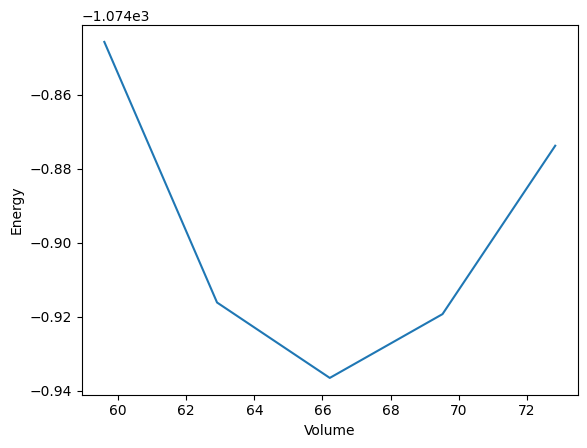

In [5]:
result = run_locally(flow)
result